_Version log: Branch of V19. Trying out a new way of boundry checking and randomising the samples_

_Update: I resurrected V24 in order to make a nice graph demonstrating wide detectors._

In [100]:
import sys, warnings
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
from sklearn.exceptions import ConvergenceWarning
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft as spfft
from scipy.constants import c as C
from tqdm import tqdm
import CS_functions as cs
warnings.filterwarnings("ignore", category= ConvergenceWarning)
plt.rcParams.update({'font.size':20, 'xtick.minor.visible': True, 'ytick.minor.visible': False,
                     'xtick.direction': 'in', 'ytick.direction': 'in', "xtick.top": True, "ytick.right": True,
                     'lines.linewidth': 2.4, 'lines.markersize': 10.0, 'lines.markeredgewidth': 2.4})
np.set_printoptions(threshold=sys.maxsize)

In [101]:
file_name = "1dmockanderrors17"
file_type = ".csv"
pixel_pitch = 0.5 # in mm
theta = 200 # in arcmins
total_points = 15
central_freq = 0.9e12 # in Hz
FWHM_freq = 0.9e12 # in Hz
read_noise = 0.0
smoothness = 150

target = cs.generate_interferogram(total_points, pixel_pitch *1e-3, central_freq, FWHM_freq, theta /60, read_noise_sigma= read_noise)
displacement = np.arange((1-total_points)//2, (1+total_points)//2, dtype= float)
displacement *= pixel_pitch
displacement = np.fft.ifftshift(displacement)

target_smooth = cs.generate_interferogram(total_points*smoothness**2, pixel_pitch/smoothness *1e-3, central_freq, FWHM_freq, theta /60, read_noise_sigma= read_noise)
displacement_smooth = np.arange((1-total_points*smoothness**2)//2, (1+total_points*smoothness**2)//2, dtype= float)
displacement_smooth *= pixel_pitch /smoothness
displacement_smooth = np.fft.ifftshift(displacement_smooth)

In [ ]:
IRF_FWHM = 1.34 # in mm
sinc_half = 1.895494 # result taken from wolfram alpha. true for sinc(x) = sin(x)/x = 1/2, solve for x.
K_FWHM = sinc_half*2 /(np.pi * IRF_FWHM) # rescaling factor

IRF = K_FWHM * np.sinc(K_FWHM*displacement) # rescale by new FWHM such that the fourier transform peaks at 1
IRF_FFT = np.fft.rfft(IRF, norm= "backward") *pixel_pitch # NORMALISE IN REAL UNITS (mm)
IRF_spec = np.abs(IRF_FFT)
IRF_smooth = K_FWHM * np.sinc(K_FWHM*displacement_smooth) # rescale by new FWHM such that the fourier transform peaks at 1
IRF_smooth_FFT = np.fft.rfft(IRF_smooth, norm= "backward") *pixel_pitch/smoothness
IRF_smooth_spec = np.abs(IRF_smooth_FFT)

target_FFT = np.fft.rfft(target, norm= "backward") *pixel_pitch
target_spec = np.abs(target_FFT)
target_smooth_FFT = np.fft.rfft(target_smooth, norm= "backward") *pixel_pitch/smoothness
target_smooth_spec = np.abs(target_smooth_FFT)

convol_FFT = target_FFT *IRF_FFT
convol_spec = np.abs(convol_FFT)
convol = np.fft.irfft(convol_FFT, norm= "backward", n= total_points) /pixel_pitch
convol_smooth_FFT = target_smooth_FFT *IRF_smooth_FFT
convol_smooth_spec = np.abs(convol_smooth_FFT)
convol_smooth = np.fft.irfft(convol_smooth_FFT, norm= "backward", n= total_points*smoothness**2) /(pixel_pitch/smoothness)

wavenum = np.fft.rfftfreq(len(target), pixel_pitch) # in mm^-1
freqs = wavenum*10**3 * C / (2*np.sin(np.deg2rad(theta/60))) # in Hz
freqs *= 1e-12 # in THz
wavenum_smooth = np.fft.rfftfreq(len(target_smooth), pixel_pitch/smoothness) # in mm^-1
freqs_smooth = wavenum_smooth*10**3 * C / (2*np.sin(np.deg2rad(theta/60))) # in Hz
freqs_smooth *= 1e-12 # in THz

C:\Users\rcr73298\AppData\Local\Temp\ipykernel_19560\515025255.py:7: UserWarning: Legend does not support handles for Annotation instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axs[0].legend()


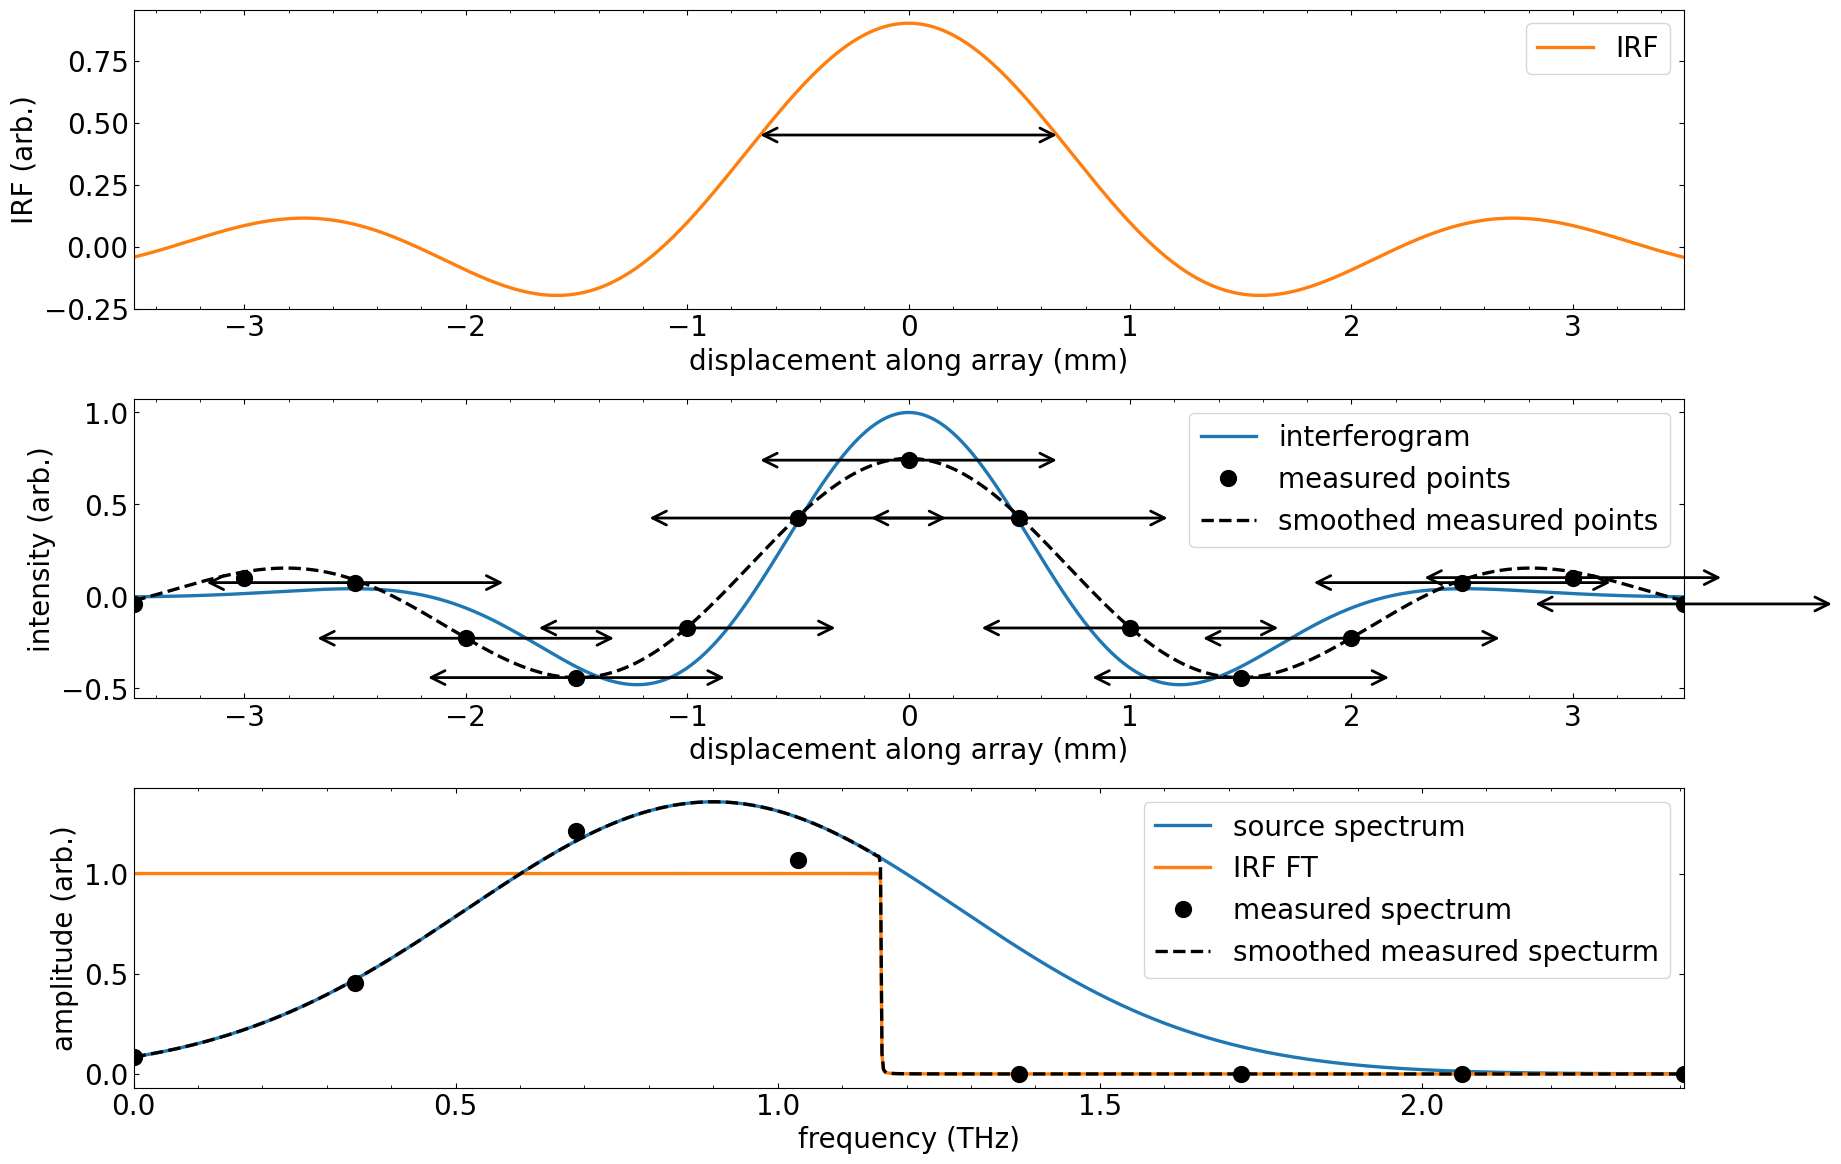

In [109]:

fig, axs = plt.subplots(3, 1, figsize= (20, 14), gridspec_kw= {"hspace": 0.3})

# axs[0].plot(np.fft.fftshift(displacement), np.fft.fftshift(IRF), linestyle= "none", marker= "o", color= "tab:blue", label= "resolvable IRF")
axs[0].plot(np.fft.fftshift(displacement_smooth), np.fft.fftshift(IRF_smooth), color= "tab:orange", label= "IRF")
axs[0].annotate("", xy= (-IRF_FWHM/2, K_FWHM/2), xytext= (IRF_FWHM/2, K_FWHM/2), arrowprops= {"arrowstyle": "<->", "shrinkA": 0, "shrinkB": 0, "linewidth": 2, "mutation_scale": 25}, label= "diode width")
axs[0].set(xlabel= "displacement along array (mm)", ylabel= "IRF (arb.)", xlim= (displacement.min(), displacement.max()))
axs[0].legend()

axs[1].plot(np.fft.fftshift(displacement_smooth), target_smooth, color= "tab:blue", label= "interferogram")
axs[1].plot(np.fft.fftshift(displacement), convol, color= "k", linestyle= "none", marker= "o", label= "measured points")
for x, I in zip(np.fft.fftshift(displacement), convol):
    axs[1].annotate("", xy= (x -IRF_FWHM/2, I), xytext= (x +IRF_FWHM/2, I), arrowprops= {"arrowstyle": "<->", "shrinkA": 0, "shrinkB": 0, "linewidth": 2, "mutation_scale": 25})

axs[1].plot(np.fft.fftshift(displacement_smooth), convol_smooth, color= "k", linestyle= "--", label= "smoothed measured points")
axs[1].set(xlabel= "displacement along array (mm)", ylabel= "intensity (arb.)", xlim= (displacement.min(), displacement.max()))
axs[1].legend()

#axs[2].plot(freqs, target_spec, linestyle= "none", marker= "o", color= "tab:blue", label= "resolvable source spectrum")
axs[2].plot(freqs_smooth, target_smooth_spec, color= "tab:blue", label= "source spectrum")
#axs[2].plot(freqs, IRF_spec, linestyle= "none", marker= "o", color= "tab:orange", label= "resolvable IRF FT")
axs[2].plot(freqs_smooth, IRF_smooth_spec, color= "tab:orange", label= "IRF FT")
axs[2].plot(freqs, convol_spec, linestyle= "none", marker= "o", color= "k", label= "measured spectrum")
axs[2].plot(freqs_smooth, convol_smooth_spec, color= "k", linestyle= "--", label= "smoothed measured specturm")
axs[2].set(xlabel= "frequency (THz)", ylabel= "amplitude (arb.)", xlim= (freqs.min(), freqs.max()))
axs[2].legend()

plt.show()